# Telecom Company Customer Churn Prediction 🛰












# Objectives
We will build a **customer churn classifier**!

# Guidelines
The project is about a telecom company: they want to predict if a customer is about to leave. We will combine both **unsupervised (clustering)** and **supervised approaches (classification)**.

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # when using smote, this Pipeline has to be used. Otherwise, sklearn's won't work.
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import scipy.stats as st
from xgboost import plot_tree
from xgboost import plot_importance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data exploration

In [2]:
PATH = os.path.join('..', 'data', 'Telco-Customer-Churn.csv')

In [3]:
df = pd.read_csv(PATH)

In [4]:
df.head(3)

,customerID,sex,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   sex               7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.shape

(7043, 21)

In [7]:
df.isnull().sum()

customerID          0
sex                 0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.columns

Index(['customerID', 'sex', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Features are the following:

- `customerID`: a unique ID for each customer
- `sex`: the gender of the customer
- `SeniorCitizen`: whether the customer is a senior (i.e. older than 65) or not
- `Partner`: whether the customer has a partner or not
- `Dependents`: whether the customer has people to take care of or not
- `tenure`: the number of months the customer has stayed
- `PhoneService`: whether the customer has a phone service or not
- `MultipleLines`: whether the customer has multiple telephonic lines or not
- `InternetService`: the kind of internet services the customer has (DSL, Fiber optic, no)
- `OnlineSecurity`: what online security the customer has (Yes, No, No internet service)
- `OnlineBackup`: whether the customer has online backup file system (Yes, No, No internet service)
- `DeviceProtection`: Whether the customer has device protection or not (Yes, No, No internet service)
- `TechSupport`: whether the customer has tech support or not (Yes, No, No internet service)
- `StreamingTV`: whether the customer has a streaming TV device (e.g. a TV box) or not (Yes, No, No internet service)
- `StreamingMovies`: whether the customer uses streaming movies (e.g. VOD) or not (Yes, No, No internet service)
- `Contract`: the contract term of the customer (Month-to-month, One year, Two year)
- `PaperlessBilling`: Whether the customer has electronic billing or not (Yes, No)
- `PaymentMethod`: payment method of the customer (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- `MonthlyCharges`: the amount charged to the customer monthly
- `TotalCharges`: the total amount the customer paid

#### And the Target :
- `Churn`: whether the customer left or not (Yes, No)

#### Numercial Variables
##### continous (to scale)
- `tenure`
- `MonthlyCharges`
- `TotalCharges`
##### discrete
- `SeniorCitizen`

#### Categorical variables
- `customerID`
##### to dummify
- `MultipleLines`
- `InternetService`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`
- `Contract`
- `PaymentMethod`
- `OnlineSecurity`
##### to map
- `sex`
- `Partner`
- `Dependents`
- `PhoneService`
- `PaperlessBilling`
- `Churn`

In [5]:
(df.Churn == 'No').sum()

5174

In [6]:
(df.Churn == 'Yes').sum()

1869

In [7]:
(5174/7043)*100

73.4630129206304

In [8]:
(1869/7043)*100

26.536987079369588

# Exploratory Data Analysis

[]

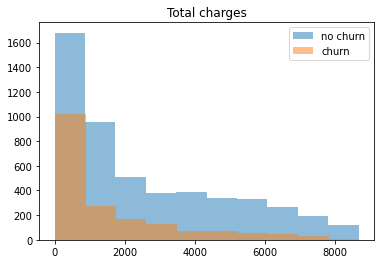

In [28]:
plt.hist(df[df['Churn']=='No']['TotalCharges'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['TotalCharges'], alpha = 0.5)
plt.title('Total charges')
plt.legend(['no churn', 'churn'])
plt.plot()

[]

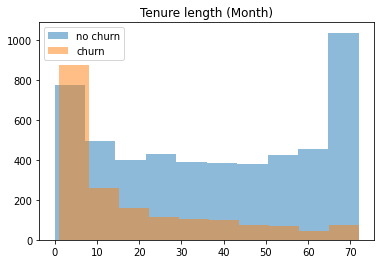

In [9]:
plt.hist(df[df['Churn']=='No']['tenure'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['tenure'], alpha = 0.5)
plt.title('Tenure length (Month)')
plt.legend(['no churn', 'churn'])
plt.plot()

We can see that the higher tenure means lower Churn Rate.

[]

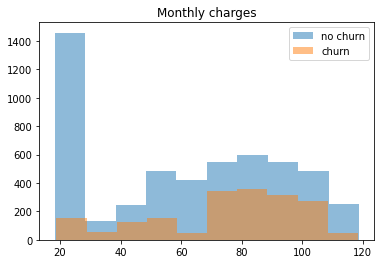

In [10]:
plt.hist(df[df['Churn']=='No']['MonthlyCharges'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['MonthlyCharges'], alpha = 0.5)
plt.title('Monthly charges')
plt.legend(['no churn', 'churn'])
plt.plot()

[]

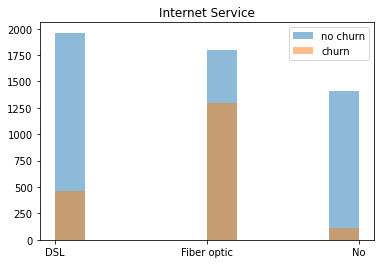

In [8]:
plt.hist(df[df['Churn']=='No']['InternetService'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['InternetService'], alpha = 0.5)
plt.title('Internet Service')
plt.legend(['no churn', 'churn'])
plt.plot()

This histogram shows us that customers who use fiber optic as an Internet service are more likely to leave. We would generally expect fiber optic customers to stay longer as they use a more premium service. But this can happen due to high prices, competition, customer service, etc.

[]

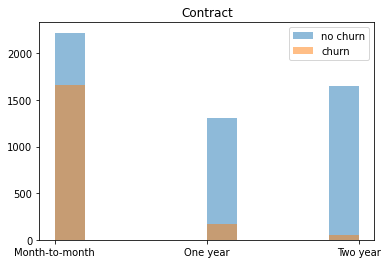

In [10]:
plt.hist(df[df['Churn']=='No']['Contract'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['Contract'], alpha = 0.5)
plt.title('Contract')
plt.legend(['no churn', 'churn'])
plt.plot()

As expected, shorter the contract the higher the churn rate.

[]

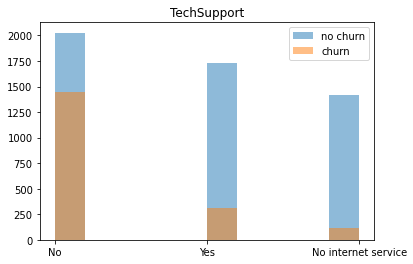

In [11]:
plt.hist(df[df['Churn']=='No']['TechSupport'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['TechSupport'], alpha = 0.5)
plt.title('TechSupport')
plt.legend(['no churn', 'churn'])
plt.plot()

Customers who use tech support are less likely to churn.

[]

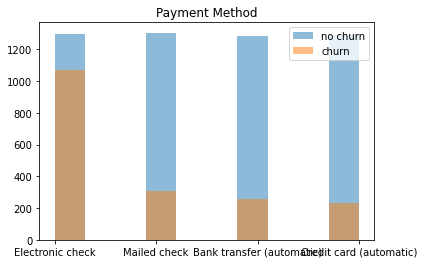

In [15]:
plt.hist(df[df['Churn']=='No']['PaymentMethod'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['PaymentMethod'], alpha = 0.5)
plt.title('Payment Method')
plt.legend(['no churn', 'churn'])
plt.plot()

Automatic payment makes the customer stay longer.

[]

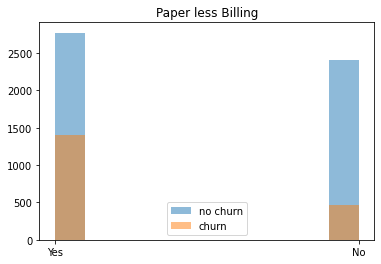

In [16]:
plt.hist(df[df['Churn']=='No']['PaperlessBilling'], alpha = 0.5)
plt.hist(df[df['Churn']=='Yes']['PaperlessBilling'], alpha = 0.5)
plt.title('Paper less Billing')
plt.legend(['no churn', 'churn'])
plt.plot()

Customer receiving electronic bills are less likely to churn.

# Clustering

### Market segmentation : 
We use clusterings models to determine meaningful clusters of customers and try to label them according to their main characteristics.

#### Elbow Method:
Shows optimal cluster number for optimal inertia.

#### Inertia:
"Inertia is the sum of squared error for each cluster. Therefore the smaller the inertia the denser the cluster (closer together all the points are).


In [5]:
# K-Means clustering 
inertia = []
K = range(1, 10)
for k in K:
    means_k = KMeans(n_clusters=k, random_state=0)
    means_k.fit(df.loc[:, ["tenure"]])
    inertia.append(means_k.inertia_)

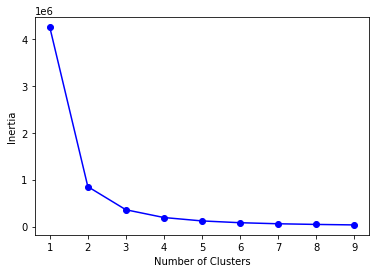

In [6]:
#Plotting the elbow

plt.plot(K , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

##### Business sense:
The plot has an arm shape, and the elbow would be the optimal K. According to the graph, it seems that 2 is the optimal one. We can also have a glimpse of our results relevance by using our business sense or topic-knowledge. Thus, we can take more or less clusters. We will be selecting 3 for this case.

In [7]:
def order_cluster(cluster_field_name, target_field_name, df):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=True).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [8]:
means_k = KMeans(n_clusters=3, init='random', max_iter=100, random_state=0)
means_k.fit(df.loc[:, ["tenure"]])

y_kmeans = means_k.predict(df.loc[:, ["tenure"]])
df['TenureCluster'] = y_kmeans

In [18]:
np.unique(df['TenureCluster'])

array([0, 1, 2], dtype=int32)

In [9]:
df = order_cluster('TenureCluster', 'tenure', df)

In [10]:
inertia = []
K = range(1, 10)
for k in K:
    means_k = KMeans(n_clusters=k, random_state=0)
    means_k.fit(df.loc[:, ["MonthlyCharges"]])
    inertia.append(means_k.inertia_)

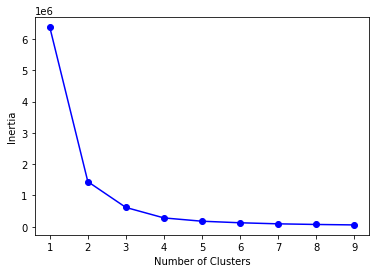

In [11]:
plt.plot(K , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [12]:
means_k = KMeans(n_clusters=3, init='random', max_iter=100, random_state=0)
means_k.fit(df.loc[:, ["MonthlyCharges"]])
y_kmeans = means_k.predict(df.loc[:, ["MonthlyCharges"]])
df['MonthlyChargesCluster'] = y_kmeans

In [13]:
df = order_cluster('MonthlyChargesCluster', 'MonthlyCharges', df)

In [5]:
#convert to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
df['TotalCharges'] = np.nan_to_num(df['TotalCharges'])

In [7]:
df = df.dropna()

In [17]:
inertia = []
K = range(1, 10)
for k in K:
    means_k = KMeans(n_clusters=k, random_state=0)
    means_k.fit(df.loc[:, ['TotalCharges']])
    inertia.append(means_k.inertia_)

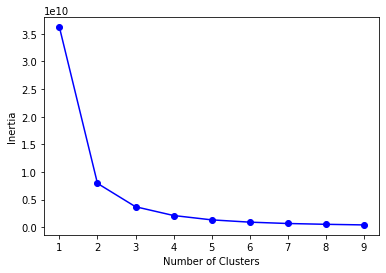

In [18]:
plt.plot(K , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [19]:
means_k = KMeans(n_clusters=3, init='random', max_iter=100, random_state=0)
means_k.fit(df.loc[:, ['TotalCharges']])
y_kmeans = means_k.predict(df.loc[:, ['TotalCharges']])
df['TotalChargesCluster'] = y_kmeans

In [20]:
df = order_cluster('TotalChargesCluster', 'TotalCharges', df)

In [21]:
df['TenureCluster'] = df["TenureCluster"].replace({0:'low_tenure', 1:'mid_tenure', 2:'high_tenure'})
df['MonthlyChargesCluster'] = df["MonthlyChargesCluster"].replace({0:'low_mnth', 1:'mid_mnth', 2:'high_mnth'})
df['TotalChargesCluster'] = df["TotalChargesCluster"].replace({0:'low_total', 1:'mid_total', 2:'high_total'})

# Feature engineering

### dummification

In [23]:
to_dummify = df.drop(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], axis=1)

In [24]:
dummies = pd.get_dummies(to_dummify)
dummies.columns

Index(['sex_Female', 'sex_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank t

In [25]:
dummies = dummies.drop(['sex_Male', 'Partner_No', 'Dependents_No', 'PhoneService_Yes', 'PaperlessBilling_No'], axis=1)
dummies.columns, dummies.shape

(Index(['sex_Female', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_No',
        'MultipleLines_No', 'MultipleLines_No phone service',
        'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'InternetService_No',
        'OnlineSecurity_No', 'OnlineSecurity_No internet service',
        'OnlineSecurity_Yes', 'OnlineBackup_No',
        'OnlineBackup_No internet service', 'OnlineBackup_Yes',
        'DeviceProtection_No', 'DeviceProtection_No internet service',
        'DeviceProtection_Yes', 'TechSupport_No',
        'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
        'StreamingTV_No internet service', 'StreamingTV_Yes',
        'StreamingMovies_No', 'StreamingMovies_No internet service',
        'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
        'Contract_Two year', 'PaperlessBilling_Yes',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
       

### scaling
Units are not the same for these 3 continuous variables. This why we have to scale them.

In [26]:
to_scale = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
to_scale.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,10,29.75,301.90
2,16,18.95,326.80
3,1,39.65,39.65
4,12,19.80,202.25


In [27]:
X = pd.concat([to_scale, dummies, df['SeniorCitizen']], axis=1)
print(X.shape)

y = np.zeros(len(df))
y[df['Churn']=='Yes']=1
y[df['Churn']=='No']=0
print(y.shape)

(7043, 49)
(7043,)


In [39]:
# Now we can vizualise and evaluate clusters

#### Silhouette:
The Silhouette Score is from -1 to 1 and shows how close or far away the clusters are from each other and how dense the clusters are."

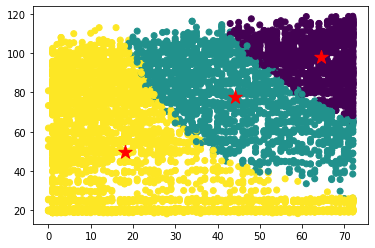

In [13]:
kmeans = KMeans(n_clusters=3, init='random', max_iter=100, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_

silhouette = silhouette_samples(X.loc[:, ["tenure"]].to_numpy(), labels)

plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=labels)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker="*", s=200, c='red')

In [14]:
np.unique(silhouette)

array([-0.87676022, -0.87625049, -0.8753014 , -0.8739929 , -0.8722322 ,
       -0.86991357, -0.86688159, -0.86393924, -0.85845277, -0.85607103,
       -0.84641056, -0.83500476, -0.82149079, -0.80596408, -0.78877185,
       -0.76966308, -0.74871727, -0.74681758, -0.74530842, -0.74505665,
       -0.7396402 , -0.73891853, -0.730148  , -0.7269958 , -0.72525907,
       -0.71647171, -0.69996442, -0.69807996, -0.67475886, -0.67241947,
       -0.64648522, -0.64251178, -0.63918365, -0.63896001, -0.63836909,
       -0.63751329, -0.63608498, -0.63526697, -0.63208473, -0.62626647,
       -0.61870104, -0.61306702, -0.60874689, -0.59623625, -0.58085167,
       -0.5733558 , -0.56249213, -0.5417713 , -0.52759342, -0.51795711,
       -0.49080911, -0.48008523, -0.4762461 , -0.46067485, -0.4519293 ,
       -0.42646149, -0.41867266, -0.41850844, -0.40007991, -0.38800358,
       -0.3793846 , -0.36105098, -0.35471759, -0.34539118, -0.33302728,
       -0.31741538, -0.29757907, -0.28288418, -0.278883  , -0.26

#### No fit before split! 
In order to avoid data leaking whilst scaling, we have to split data into train and test, before fitting with the scaling process.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [29]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basic Modeling

## Pipeline
- We're gonna use a pipeline in order to apply the DRY principle, i.e, Don't Repeat Yourself !
- This is going to help us to choose the best classifier amongst: Logistic regression, Support Vector Machine, Random Forest Classifier, Gradient Boosting Classifier, XGBoost Classifier.

In [30]:
scores = []

classifiers = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), xgb.XGBClassifier()]

for c in classifiers:
    steps = [
             ('classifier', c)
    ]

    #Build preprocessing pipeline

    pipe = Pipeline(steps=steps)


    pipe.fit(X_train_scaled, y_train)
    y_pred = pipe.predict(X_test_scaled)
    report = classification_report(y_test, y_pred)
    print(f'scores for classifier {c}: \n', report, '\n\n')
    scores.append(report)

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


scores for classifier LogisticRegression(): 
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1035
         1.0       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409
 


scores for classifier RandomForestClassifier(): 
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1035
         1.0       0.59      0.50      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409
 


scores for classifier SVC(): 
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      1035
         1.0       0.61      0.50      0.55       374

    accuracy                           0.78      

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


scores for classifier XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None): 
               precision    recall  f1-score   support

         0.0       0.82      0.87      0.85      1035
         1.0       0.57      0.49      0.53       374

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409
 




## SMOTE
- We add a smote because the two classes are imbalanced. 

In [31]:
scores = []

classifiers = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), xgb.XGBClassifier()]

for c in classifiers:
    steps = [
             ('smote', SMOTE(random_state=42, n_jobs=-1)),
             ('classifier', c)
    ]

    #Build preprocessing pipeline

    pipe = Pipeline(steps=steps)


    pipe.fit(X_train_scaled, y_train)
    y_pred = pipe.predict(X_test_scaled)
    report = classification_report(y_test, y_pred)
    print(f'scores for classifier {c}: \n', report, '\n\n')
    scores.append(report)

scores for classifier LogisticRegression(): 
               precision    recall  f1-score   support

         0.0       0.90      0.72      0.80      1035
         1.0       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409
 


scores for classifier RandomForestClassifier(): 
               precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1035
         1.0       0.55      0.56      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.76      0.76      1409
 


scores for classifier SVC(): 
               precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      1035
         1.0       0.53      0.72      0.61       374

    accuracy                           0.75      

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
scores for classifier XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None): 
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1035
  

#### smote helped a bit to improve the results. Let's now combine: smote and tuning hyperparameters for each classifier.

# Define hyperparameters for each classifier

In [33]:
lr_params = {
    "classifier__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "classifier__penalty": [None, 'l1', 'l2', 'elasticnet'],
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "classifier__class_weight": ['balanced', 'balanced_subsample', None]
}


rf_params = {
    "classifier__max_depth": [5, 10, 20, 30, None], 
    "classifier__n_estimators": [10, 30, 50], 
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__class_weight": ['balanced', 'balanced_subsample', None]}


svc_params = {"classifier__kernel": ['poly', 'rbf', 'sigmoid'],
              "classifier__C": [50, 10, 1.0, 0.1, 0.01],
              "classifier__gamma": ['scale']
             }
    
gb_params = {"classifier__n_estimators": [10, 100, 1000],
             "classifier__learning_rate": [0.001, 0.01, 0.1], 
             "classifier__subsample": [0.5, 0.7, 1.0],
             "classifier__max_depth": [3, 7, 9]
            }
    
xgb_params = {
    "classifier__n_estimators": st.randint(3, 50),
    "classifier__learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "classifier__max_depth": [3, 4, 5, 6, 8, 10, 12, 15, 30, 100],
    "classifier__min_child_weight": [1, 3, 5, 7, 11],
    "classifier__subsample": [1, 0.9, 0.8],
    "classifier__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
    "classifier__colsample_bytree": [0.3, 0.4, 0.5 , 0.7]
    
}

hyperparameters = [lr_params, rf_params, svc_params, gb_params, xgb_params]

## StratifiedKFold
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [34]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold)

In [99]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [35]:
for c, h in zip(classifiers, hyperparameters):
    s = [
        ('smote', SMOTE(random_state=42, n_jobs=-1)),
        ('classifier', c)
    ]

    # Build preprocessing pipeline

    my_pipeline = Pipeline(steps=s)
    
    random_search = RandomizedSearchCV(my_pipeline, 
                                   param_distributions=h, 
                                   n_iter=5, 
                                   scoring='f1', 
                                   n_jobs=-1, 
                                   cv=skf, 
                                   verbose=1, 
                                   random_state=42)
    
    
    random_search.fit(X_train_scaled, y_train)
    my_pipeline.fit(X_train_scaled, y_train)
    y_pred = my_pipeline.predict(X_test_scaled)
    print(f'For {c}:\n random_search.best_params: {random_search.best_params_} \n random_search.best_score: {random_search.best_score_*100}\n\n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.63702365        nan 0.63702365        nan]
  category=UserWarning
/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For LogisticRegression():
 random_search.best_params: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__class_weight': 'balanced_subsample', 'classifier__C': 100} 
 random_search.best_score: 63.70236496879998


Fitting 5 folds for each of 5 candidates, totalling 25 fits
For RandomForestClassifier():
 random_search.best_params: {'classifier__n_estimators': 10, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced'} 
 random_search.best_score: 62.47776825247531


Fitting 5 folds for each of 5 candidates, totalling 25 fits
For SVC():
 random_search.best_params: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 0.01} 
 random_search.best_score: 62.61233180354226


Fitting 5 folds for each of 5 candidates, totalling 25 fits
For GradientBoostingClassifier():
 random_search.best_params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 9, 'classifier__learning_

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None):
 random_search.best_params: {'classifier__colsample_bytree': 0.4, 'classifier__gamma': 0.3, 'classifier__learning_rate': 0.2, 'clas

#### The best score obtained with SMOTE and optimization of the classifiers hyperparameters: F-score = 0.64 for XGBoost

In [36]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

In [37]:
X_res_df = pd.DataFrame(X_res, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) # we have to retrieve the columns in order to display deatures names

In [38]:
xgboost = xgb.XGBClassifier(colsample_bytree= 0.4, 
                            gamma=0.3, 
                            learning_rate=0.2, 
                            max_depth=3,
                            min_child_weight=7,
                            n_estimators=24,
                            subsample=1)

xgboost.fit(X_res_df, y_res)

y_pred = xgboost.predict(X_test_scaled_df)


/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Let's now try to identify which variables are the most important.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

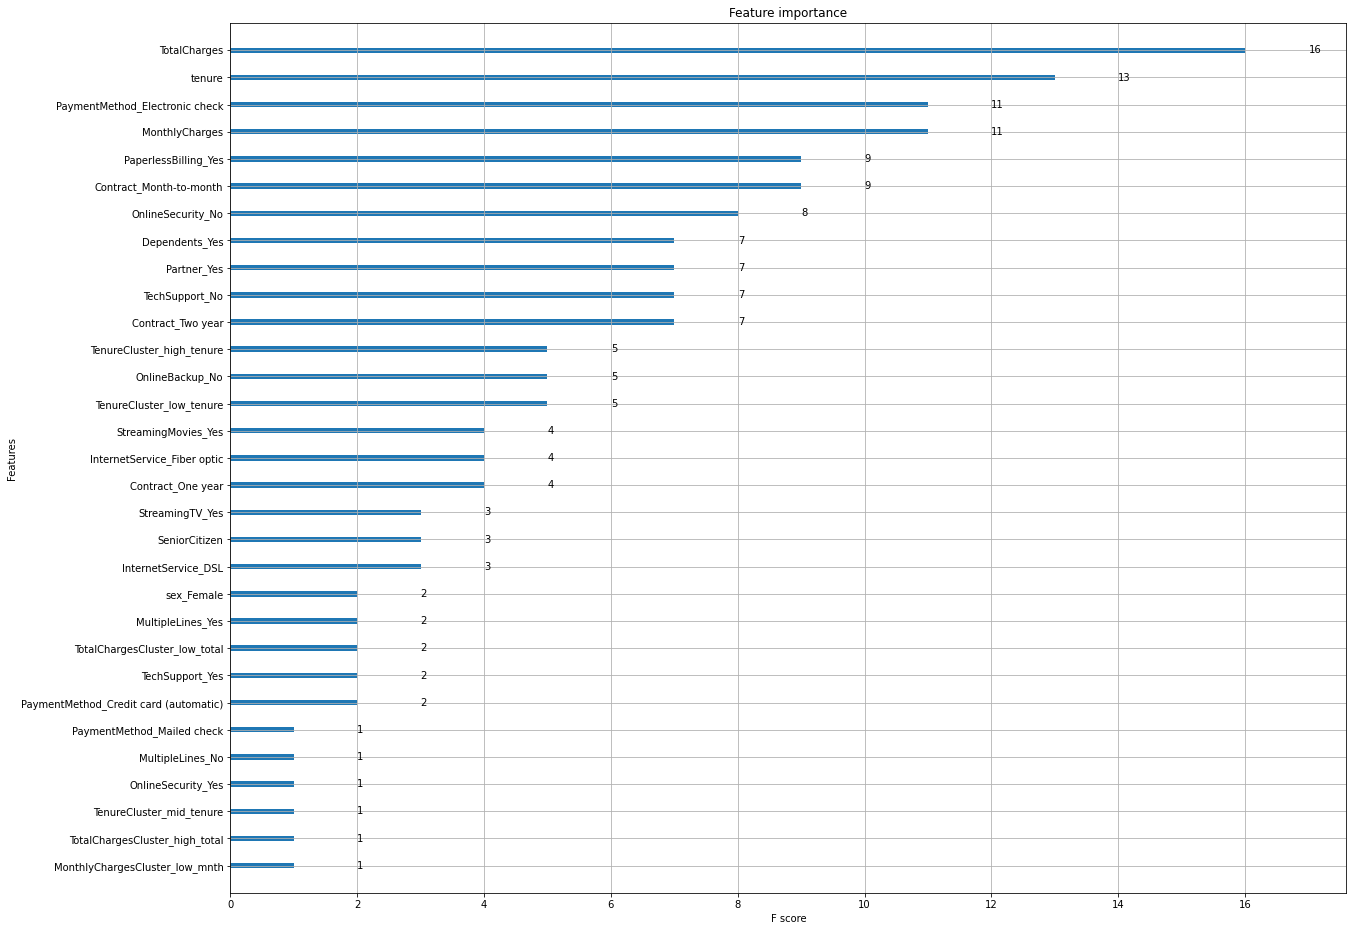

In [39]:
# set up the parameters
fig, ax = plt.subplots(figsize=(20, 16))
plot_importance(xgboost, ax=ax)

**We can see that our model assigned more importance to TotalCharges and tenure compared to other features.**

#!pip3 install xgboost
#!brew install libomp
#!pip install plotly
#!pip install --user scikit-learn